In [ ]:
!pip install -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 5.4 MB/s eta 0:00:00


In [ ]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dropout, LeakyReLU, Dense
from sklearn.model_selection import train_test_split
import keras_tuner as kt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import plotly.express as px

In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 34.7 MB/s eta 0:00:00


In [ ]:
params = {
    'latitude': 22.572645,
    'longitude' :88.363892,
    'start_date' : '2023-06-01',
    'end_date': '2023-07-30',
    'hourly': {'temperature_2m','relativehumidity_2m','windspeed_10m'}
}
result = requests.get("https://api.open-meteo.com/v1/forecast",params = params).json()
print(result)

{'latitude': 22.625, 'longitude': 88.375, 'generationtime_ms': 63.768982887268066, 'utc_offset_seconds': 0, 'timezone': 'GMT', 'timezone_abbreviation': 'GMT', 'elevation': 12.0, 'hourly_units': {'time': 'iso8601', 'temperature_2m': '°C', 'relativehumidity_2m': '%', 'windspeed_10m': 'km/h'}, 'hourly': {'time': ['2023-06-01T00:00', '2023-06-01T01:00', '2023-06-01T02:00', '2023-06-01T03:00', '2023-06-01T04:00', '2023-06-01T05:00', '2023-06-01T06:00', '2023-06-01T07:00', '2023-06-01T08:00', '2023-06-01T09:00', '2023-06-01T10:00', '2023-06-01T11:00', '2023-06-01T12:00', '2023-06-01T13:00', '2023-06-01T14:00', '2023-06-01T15:00', '2023-06-01T16:00', '2023-06-01T17:00', '2023-06-01T18:00', '2023-06-01T19:00', '2023-06-01T20:00', '2023-06-01T21:00', '2023-06-01T22:00', '2023-06-01T23:00', '2023-06-02T00:00', '2023-06-02T01:00', '2023-06-02T02:00', '2023-06-02T03:00', '2023-06-02T04:00', '2023-06-02T05:00', '2023-06-02T06:00', '2023-06-02T07:00', '2023-06-02T08:00', '2023-06-02T09:00', '2023-06

In [ ]:
df = pd.DataFrame(result['hourly'])
df.head()

,time,temperature_2m,relativehumidity_2m,windspeed_10m
0,2023-06-01T00:00,29.2,90,3.7
1,2023-06-01T01:00,30.1,86,5.4
2,2023-06-01T02:00,31.5,80,6.2
3,2023-06-01T03:00,33.0,74,7.9
4,2023-06-01T04:00,34.7,66,7.1


array([<Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>], dtype=object)

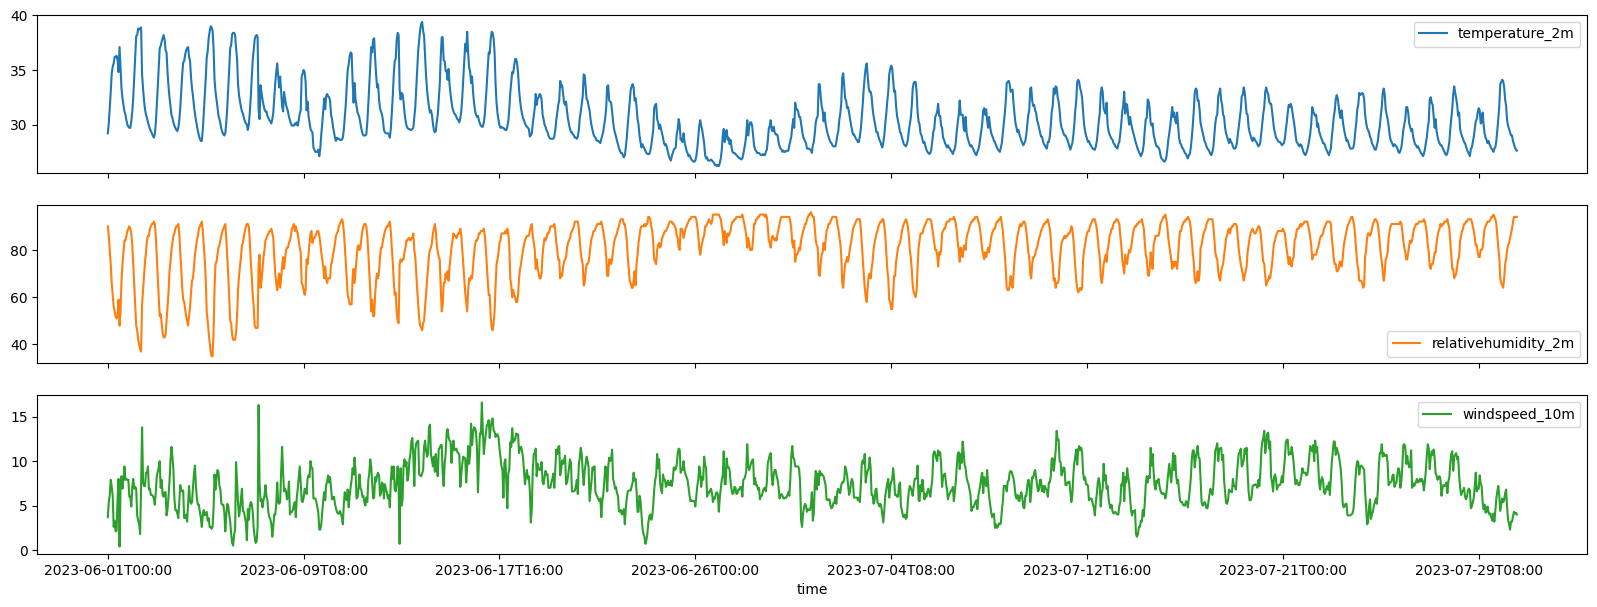

In [ ]:
df.set_index("time", inplace = True)
df.plot(figsize = (20,7), subplots = True)

In [ ]:
scaler = MinMaxScaler()
data = scaler.fit_transform(df)

In [ ]:
x_train,x_test, y_train,y_test = train_test_split(data,data[:,2],train_size = 0.8,shuffle = False)

In [ ]:
fig = px.line(df, x=df.index, y='windspeed_10m', title='Wind Speed')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

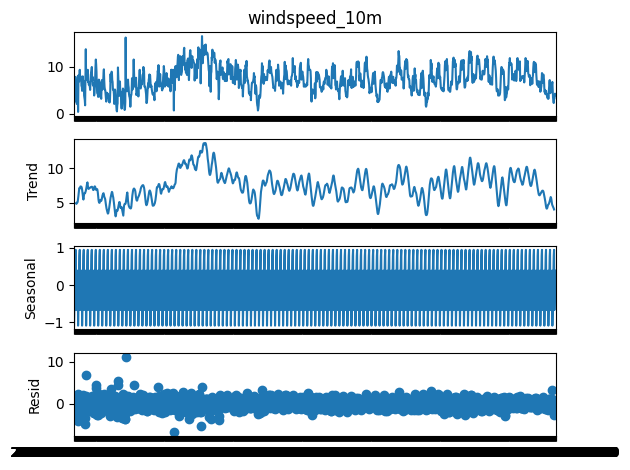

In [ ]:
decomposition = seasonal_decompose(df["windspeed_10m"], period = 12, model = 'additive')
figure = decomposition.plot()
figure.figsize = (20,5)
plt.show()

In [ ]:
data

array([[0.22727273, 0.90163934, 0.2037037 ],
       [0.29545455, 0.83606557, 0.30864198],
       [0.40151515, 0.73770492, 0.35802469],
       ...,
       [0.12878788, 0.96721311, 0.22839506],
       [0.11363636, 0.96721311, 0.2345679 ],
       [0.10606061, 0.96721311, 0.22222222]])

In [ ]:
x_train.shape[0]

1152

In [ ]:
x_test.shape[0]

288

In [ ]:
win_length = 10
batch_size = 5
num_features = 3
train_generator = TimeseriesGenerator(x_train,y_train, win_length, batch_size = batch_size)
test_generator = TimeseriesGenerator(x_test,y_test, win_length, batch_size = batch_size)

In [ ]:
model = Sequential()
model.add(LSTM(24, input_shape = (win_length, num_features), return_sequences = True))
model.add(LeakyReLU(alpha = 0.2))
model.add(Dropout(0.5))
model.add(LSTM(24, return_sequences = True))
model.add(LeakyReLU(alpha = 0.2))
model.add(LSTM(24, return_sequences = False))
model.add(LeakyReLU(alpha = 0.2))
model.add(Dense(1))
model.compile(loss = "mean_squared_error", metrics = "mean_squared_error")

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 15)

In [ ]:
history = model.fit(train_generator,epochs = 100,validation_data = test_generator,shuffle = False, callbacks = [callback])

Epoch 1/100
229/229 [==============================] - 8s 17ms/step - loss: 0.0232 - mean_squared_error: 0.0232 - val_loss: 0.0203 - val_mean_squared_error: 0.0203
Epoch 2/100
229/229 [==============================] - 3s 15ms/step - loss: 0.0182 - mean_squared_error: 0.0182 - val_loss: 0.0197 - val_mean_squared_error: 0.0197
Epoch 3/100
229/229 [==============================] - 2s 11ms/step - loss: 0.0171 - mean_squared_error: 0.0171 - val_loss: 0.0183 - val_mean_squared_error: 0.0183
Epoch 4/100
229/229 [==============================] - 2s 11ms/step - loss: 0.0158 - mean_squared_error: 0.0158 - val_loss: 0.0181 - val_mean_squared_error: 0.0181
Epoch 5/100
229/229 [==============================] - 3s 13ms/step - loss: 0.0147 - mean_squared_error: 0.0147 - val_loss: 0.0177 - val_mean_squared_error: 0.0177
Epoch 6/100
229/229 [==============================] - 3s 11ms/step - loss: 0.0145 - mean_squared_error: 0.0145 - val_loss: 0.0168 - val_mean_squared_error: 0.0168
Epoch 7/100
229/

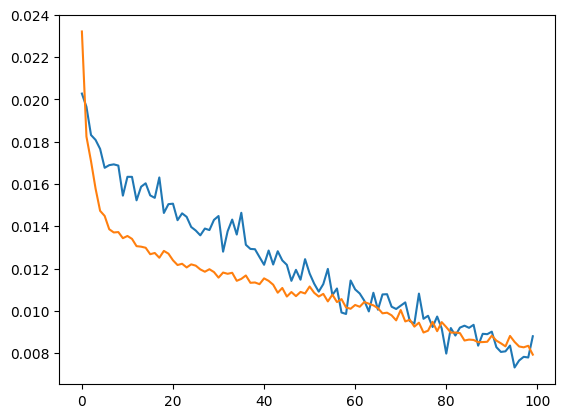

In [ ]:
plt.plot(history.history["val_loss"],label=  "val_loss")
plt.plot(history.history["loss"],label = "loss")

In [ ]:
model.save("model_windspeed.keras")

In [ ]:
prediction  = model.predict_generator(test_generator)

<ipython-input-27-7963bfab3b74>:1: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



In [ ]:
test_data = pd.DataFrame(scaler.inverse_transform(pd.concat([pd.DataFrame(x_test[:,:2]),pd.DataFrame(y_test)],axis = 1)))
test_data

,0,1,2
0,27.9,91.0,6.8
1,28.3,90.0,8.4
2,29.1,85.0,9.8
3,29.8,80.0,10.9
4,30.6,77.0,10.9
...,...,...,...
283,28.5,92.0,3.8
284,28.2,94.0,4.3
285,27.9,94.0,4.1
286,27.7,94.0,4.2


In [ ]:
time = df.index
pred_time = time[1152:]

In [ ]:
pred_df = pd.concat([pd.DataFrame(x_test[:,:2][win_length:]),pd.DataFrame(prediction[:,-1])], axis = 1)
pred_df =  pd.DataFrame(scaler.inverse_transform(pred_df))
pred_df.iloc[:][2]

0      8.965113
1      7.803542
2      7.252340
3      6.548735
4      5.815444
         ...   
273    4.646013
274    4.696996
275    5.079959
276    5.512933
277    6.229635
Name: 2, Length: 278, dtype: float64

In [ ]:
df_pred = pd.DataFrame(pred_df.iloc[:][2])
df_test = pd.DataFrame(test_data[win_length:][2])
df_pred.index = pred_time[win_length:]
df_test.index = pred_time[win_length:]

In [ ]:
df_compare = pd.concat([df_pred,df_test], axis = 1)
df_compare.columns = ["prediction","actual"]

<Axes: xlabel='time'>

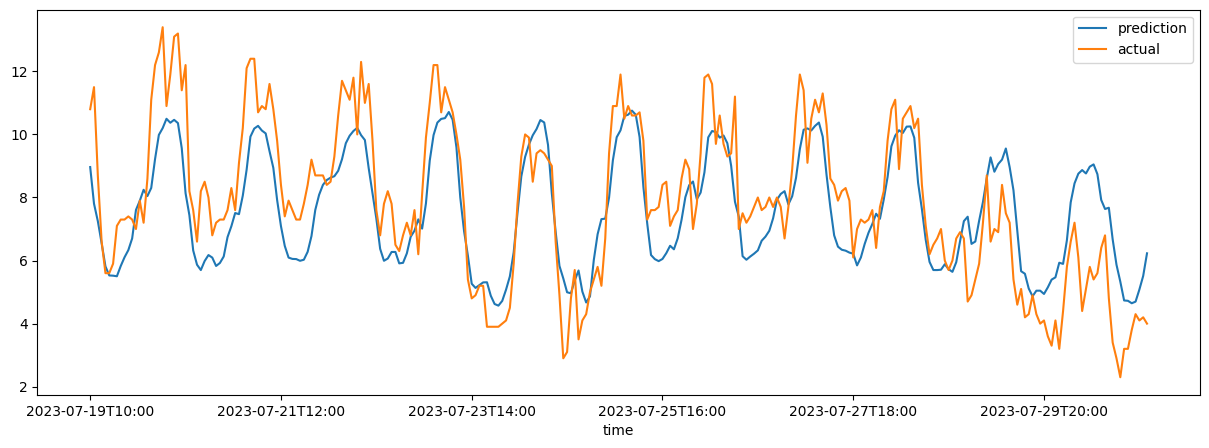

In [ ]:
df_compare.plot(figsize = (15,5))